In [1]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy

import jax.numpy as jnp

In [2]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32(t,tau):
    Dt = t - np.array([t]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [3]:
np.random.seed(seed=1)
N = 101
t = np.linspace(0,10,N)
ave = np.zeros(N)
tau = 0.4
a=1.0
ave = jnp.zeros(N)
cov = a*RBF(t,tau) #cov = Matern32(t,tau)
di = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
sigma=0.6
d=di+np.random.normal(0.0,sigma,len(di))

Text(0.5, 0, 't')

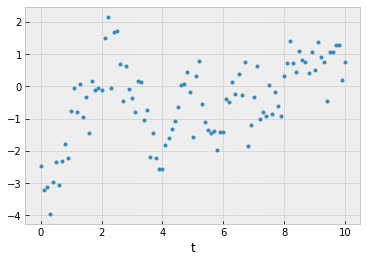

In [4]:
import seaborn as sns
plt.style.use('bmh')
plt.plot(t,d,".")
plt.xlabel("t")

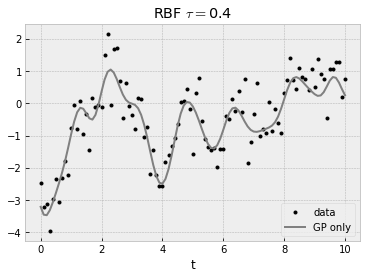

In [5]:



#cov@Pid@d
plt.plot(t,d,".",color="black",label="data")
plt.plot(t,di,color="gray",label="GP only")
plt.xlabel("t")
plt.title("RBF $\\tau=$"+str(tau))
plt.legend()
plt.savefig("gp1.pdf")

In [6]:
def modelcov(t,tau,a,sigma):
    Dt = t - jnp.array([t]).T
    K=a*jnp.exp(-(Dt)**2/2/(tau**2))+jnp.eye(N)*sigma**2
    return K

In [7]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(t,y):
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    tau = numpyro.sample('tau', dist.Exponential(1.))
    a = numpyro.sample('a', dist.Exponential(1.))
    cov = modelcov(t,tau,a,sigma)

    numpyro.sample('y', dist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=cov), obs=y)

In [9]:
from numpyro.infer import MCMC, NUTS
from jax import random
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples =num_samples)
mcmc.run(rng_key_, t=t, y=d)
mcmc.print_summary()

sample: 100%|████████████████████████████| 3000/3000 [00:15<00:00, 191.95it/s, 3 steps of size 8.41e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.48      0.54      1.38      0.67      2.27   1322.27      1.00
     sigma      0.61      0.05      0.60      0.53      0.68   2010.81      1.00
       tau      0.51      0.09      0.50      0.36      0.64   1310.42      1.00

Number of divergences: 0


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

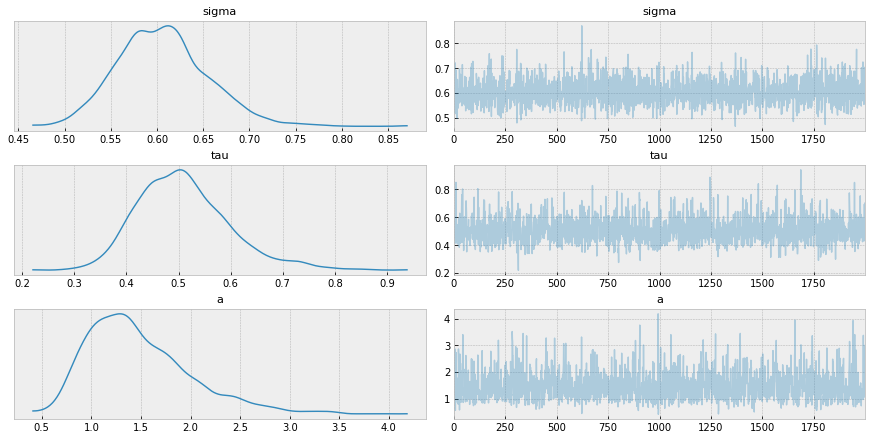

In [10]:
import arviz
arviz.plot_trace(mcmc, var_names=["sigma","tau","a"])
#plt.savefig("gp1.pdf")

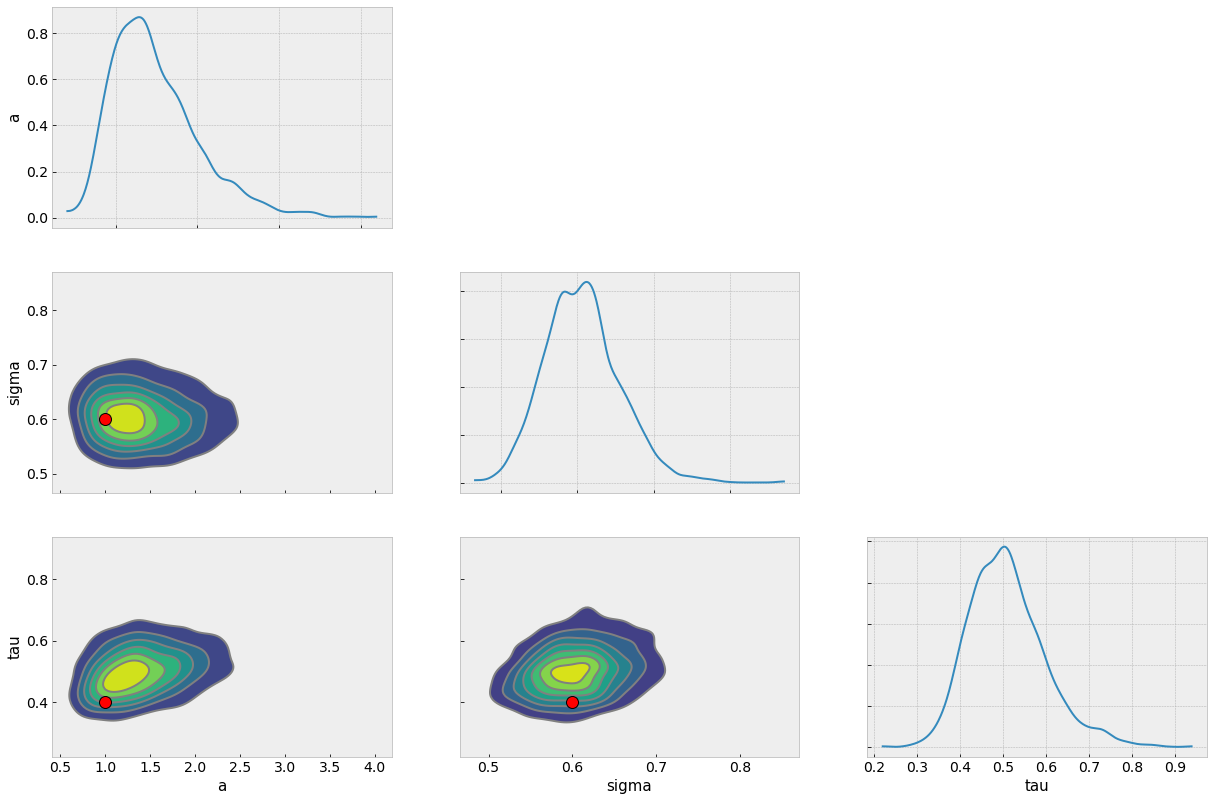

In [11]:
refs={};refs["sigma"]=sigma;refs["tau"]=tau;refs["a"]=a
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',
    divergences=False,marginals=True,reference_values=refs,
    reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("gp2.pdf", bbox_inches="tight", pad_inches=0.0)

In [12]:
posterior_a = mcmc.get_samples()['a']
posterior_tau = mcmc.get_samples()['tau']
posterior_sigma = mcmc.get_samples()['sigma']

In [13]:
np.mean(posterior_tau)

DeviceArray(0.50916296, dtype=float32)

In [14]:
from numpyro.infer import Predictive


pred = Predictive(model,{'a':posterior_a,'tau':posterior_tau,'sigma':posterior_sigma},return_sites=["y"])
predictions = pred(rng_key_,t=t,y=None)

In [15]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["y"], axis=0)
hpdi_muy = hpdi(predictions["y"], 0.9)

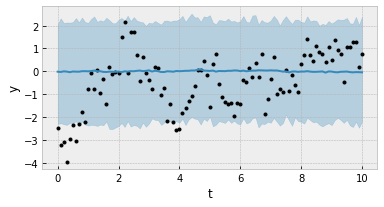

In [16]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(t,d,".",color="black")
ax.plot(t,mean_muy,color="C0")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("t")
plt.ylabel("y")
plt.savefig("gp3.pdf")

In [17]:
def muGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=sigma**2*np.eye(N)+cov
    A=scipy.linalg.solve(IKw,d,assume_a="pos")
    return cov@A

In [18]:
def covGP(tau,a,sigma):
    cov = a*RBF(t,tau)
    IKw=np.eye(N)+cov/sigma**2
    IKw=scipy.linalg.inv(IKw)
    return cov@IKw

In [19]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    ave=muGP(taus,a_s,sigmas)
    cov=covGP(taus,a_s,sigmas)
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.68it/s]


In [20]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

In [21]:
tau,sigma

(0.4, 0.6)

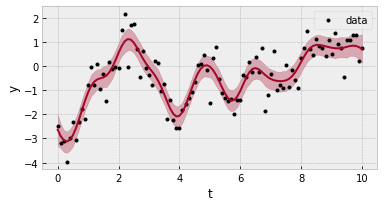

In [22]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
ax.plot(t, mean_muy,color="C1")
ax.fill_between(t, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp4.pdf")

In [23]:
def RBFx(t,td,tau):
    Dt = t - np.array([td]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    #deltaXsq = jnp.power((t[:, None] - t) /tau, 2.0)
    #K = jnp.exp(-0.5 * deltaXsq)
    return K

def Matern32x(t,td,tau):
    Dt = t - np.array([td]).T
    fac=np.sqrt(3.0)*np.abs(Dt)/tau
    K=(1.0+fac)*np.exp(-fac)
    return K

In [24]:
def mucovGPx(t,td,tau,a,sigma):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) # + sigma**2*np.eye(N)
    IKw=cov 
    A=scipy.linalg.solve(IKw,d,assume_a="pos")
    IKw = scipy.linalg.inv(IKw)
    return covx@A,covxx - covx@IKw@covx.T

In [25]:
import tqdm
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marr=[]
td=np.linspace(-3,13,101)
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    ave,cov=mucovGPx(t,td,tau,a_s,sigma)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marr.append(mk)
marr=np.array(marr)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.61it/s]


In [26]:
mean_muy = np.mean(marr, axis=0)
hpdi_muy = hpdi(marr, 0.9)

In [27]:
 list(map(int,np.random.random(10)*len(td)))

[85, 98, 85, 40, 39, 61, 92, 98, 89, 58]

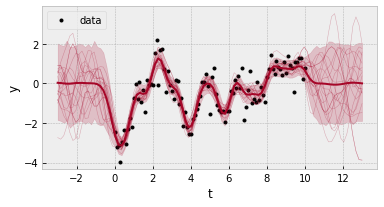

In [28]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)
ax.plot(t,d,".",color="black",label="data")
#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.2, interpolate=True,color="C1")
for i in list(map(int,np.random.random(20)*len(td))):
    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp5.pdf")

In [29]:
def mucovGPxs(t,td,tau,a,sigma):
    cov = a*RBF(t,tau) + sigma**2*np.eye(N)
    covx= a*RBFx(t,td,tau)
    covxx = a*RBF(td,tau) + sigma**2*np.eye(N)
    IKw=cov 
    A=scipy.linalg.solve(IKw,d,assume_a="pos")
    IKw = scipy.linalg.inv(IKw)
    return covx@A,covxx - covx@IKw@covx.T

In [30]:
Ns=len(posterior_sigma)
np.random.seed(seed=1)
marrs=[]
td=np.linspace(-3,13,101)
for i in tqdm.tqdm(range(0,Ns)):
    sigmas=float(posterior_sigma[i])
    taus=float(posterior_tau[i])
    a_s=float(posterior_a[i])
    ave,cov=mucovGPxs(t,td,tau,a_s,sigma)
    
    mk = smn(mean=ave ,cov=cov , allow_singular =True).rvs(1).T
    marrs.append(mk)
marrs=np.array(marrs)

mean_muys = np.mean(marrs, axis=0)
hpdi_muys = hpdi(marrs, 0.9)

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.87it/s]


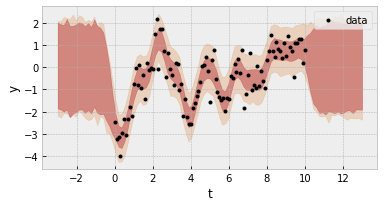

In [31]:
fig=plt.figure(figsize=(6,3 ))
ax=fig.add_subplot(111)

#mu,cov=mucovGPx(t,t,tau,sigma)
#ax.plot(t,mu)
#ax.plot(td, mean_muy,color="C1")
ax.fill_between(td, hpdi_muy[0], hpdi_muy[1], alpha=0.4, interpolate=True,color="C1")
#ax.plot(td, mean_muys,color="red")
ax.fill_between(td, hpdi_muys[0], hpdi_muys[1], alpha=0.2, interpolate=True,color="C4")
ax.plot(t,d,".",color="black",label="data")
#for i in list(map(int,np.random.random(20)*len(td))):
#    plt.plot(td,marr[i,:],lw=0.5,alpha=0.3,color="C1")
plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.savefig("gp6.pdf")